Installation

In [46]:
!pip install openai


step 1:Importing libraries

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import re
import string
import openai
import os
from openai import OpenAI
import openai



Step 2:Loading Dataset

In [48]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
data_loan = pd.read_csv('loan_data.csv')

Saving loan_data.csv to loan_data (1).csv


Extracting five rows of dataset

In [49]:
data_loan.head()

,Text,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status,Approval
0,I need a loan to pay for an international vaca...,26556,581,8314,79.26,employed,Rejected
1,I want to make home improvements like installi...,197392,389,111604,22.14,employed,Rejected
2,"I need a loan for home renovation, including a...",44561,523,34118,45.44,employed,Rejected
3,I need funds to buy new furniture and applianc...,190363,729,118757,10.22,unemployed,Rejected
4,I need a loan to start a small business.,61853,732,19210,44.13,employed,Approved


Shape(means no of rows and no of columns) of the dataset

In [50]:
data_loan.shape

(24000, 7)

Inserting data for manual testing

In [51]:
data_loan_manual_testing = data_loan.tail(10)
for i in range(23999,23989,-1):
    data_loan.drop([i], axis = 0, inplace = True)

In [52]:
data_loan.shape

(23990, 7)

In [53]:
data_loan_manual_testing.head(10)

,Text,Income,Credit_Score,Loan_Amount,DTI_Ratio,Employment_Status,Approval
23990,I need money to purchase updated equipment for...,132735,470,61080,7.59,employed,Rejected
23991,I want to buy a car for my rideshare business ...,68541,511,14576,49.47,unemployed,Rejected
23992,I want to expand my small online clothing store.,168466,307,100946,8.35,unemployed,Rejected
23993,I need funds to pay for my daughter's college ...,160132,496,100068,25.20,unemployed,Rejected
23994,I need money to invest in a franchise business...,53873,813,28127,43.33,unemployed,Rejected
23995,I need funds to pay for my daughter's college ...,195242,817,16403,24.32,employed,Approved
23996,I need financial assistance to launch my own Y...,150246,729,101572,9.97,employed,Rejected
23997,I need money to open a small bookstore and caf?.,64571,650,30533,57.35,employed,Rejected
23998,I want to buy a car for my rideshare business ...,115825,418,89837,10.37,unemployed,Rejected
23999,I need financial help to cover maternity and d...,180440,769,15259,15.06,employed,Approved


In [54]:
data_loan_manual_testing.to_csv("manual_testing.csv")
data_loan_manual_testing.columns

Index(['Text', 'Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio',
       'Employment_Status', 'Approval'],
      dtype='object')

Step 3: Data Pre-Processing and feature selection
*   Data cleaning
*   Filling missing values
*   Noisy data
*   Removal of outliners
*   Transforming categorical varibles into numerical variables













In [55]:
data_loan.isnull().sum()

,0
Text,0
Income,0
Credit_Score,0
Loan_Amount,0
DTI_Ratio,0
Employment_Status,0
Approval,0


In [56]:
data_loan.fillna('', inplace=True)
from scipy import stats
data_loan = data_loan[(np.abs(stats.zscore(data_loan.select_dtypes(include=np.number))) < 3).all(axis=1)]
data_loan = data_loan.sample(frac = 1)

In [57]:
data_loan.reset_index(inplace = True)
data_loan.drop(["index"], axis = 1, inplace = True)
data_loan.columns

Index(['Text', 'Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio',
       'Employment_Status', 'Approval'],
      dtype='object')

In [58]:
def wordopt(Text):
    Text = Text.lower()
    Text = re.sub('\[.*?\]', '', Text)
    Text = re.sub("\\W"," ",Text)
    Text = re.sub('https?://\S+|www\.\S+', '', Text)
    Text = re.sub('<.*?>+', '',Text)
    Text = re.sub('[%s]' % re.escape(string.punctuation), '', Text)
    Text = re.sub('\n', '', Text)
    Text = re.sub('\w*\d\w*', '', Text)
    return Text

In [59]:
data_loan["Text"] = data_loan["Text"].apply(wordopt)

Defining the dependent and independent variables

In [60]:
x = data_loan.drop(columns=['Approval', 'Text'])
y = data_loan['Approval']

Balancing and Extracting x and y values

In [61]:
# Step 1: Balance the data
approved = data_loan[data_loan['Approval'] == 'Approved']
rejected = data_loan[data_loan['Approval'] == 'Rejected'].sample(len(approved), random_state=42)
balanced_data = pd.concat([approved, rejected]).sample(frac=1, random_state=42)

# Step 2: Extract X and y
x = balanced_data.drop(columns=['Text', 'Approval'])
y = balanced_data['Approval']


Step 4:Data visualization

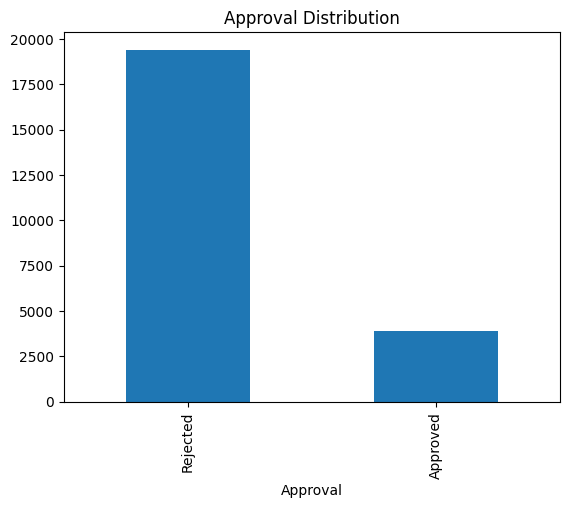

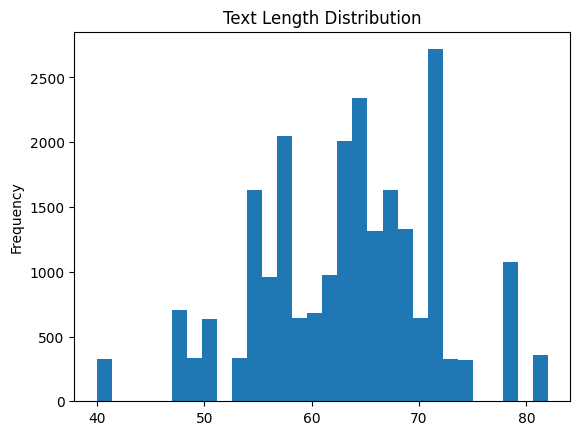

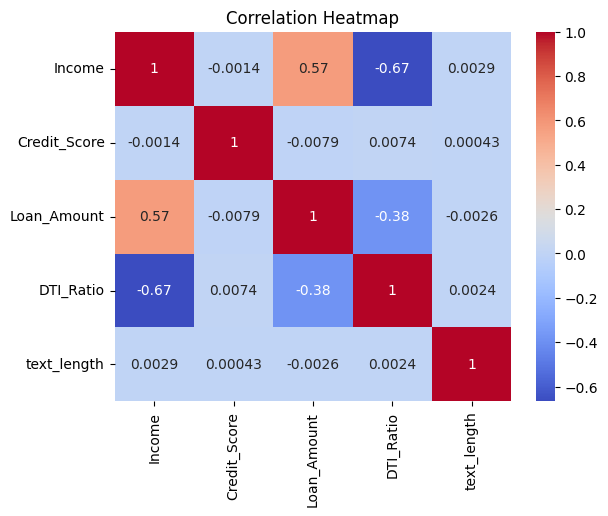

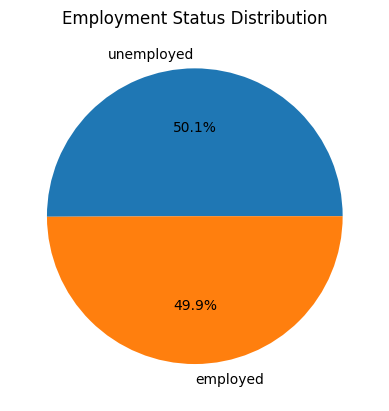

In [62]:
data_loan['Approval'].value_counts().plot(kind='bar', title='Approval Distribution')
plt.show()

data_loan['text_length'] = data_loan['Text'].apply(len)
data_loan['text_length'].plot(kind='hist', bins=30, title='Text Length Distribution')
plt.show()
# Heatmap
sns.heatmap(data_loan.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Pie Chart
data_loan['Employment_Status'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Employment Status Distribution')
plt.ylabel('')
plt.show()


Step 5:splitting and training data

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Step 1: TF-IDF on 'Text'
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(balanced_data['Text'])

# Step 2: Process numeric and categorical features
numeric_features = balanced_data.drop(columns=['Text', 'Approval'])
numeric_features_encoded = pd.get_dummies(numeric_features)

# Step 3: Ensure numeric features are float64
numeric_features_encoded = numeric_features_encoded.astype(np.float64)

# Step 4: Combine TF-IDF and numeric features
x = hstack([text_features, csr_matrix(numeric_features_encoded.values)])
y = balanced_data['Approval']

# Step 5: Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 6: Apply SMOTE (on dense version of training data)
xv_train_dense = x_train.toarray()
smote = SMOTE(random_state=42)
xv_train_res, y_train_res = smote.fit_resample(xv_train_dense, y_train)


Step 6:Model is loaded and fitted

In [65]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train_res, y_train_res)  # ✅ Proper training

RandomForestClassifier(random_state=0)

Step 7:Evaluating the model

In [66]:
# If x_test is sparse, convert to dense to match training
xv_test_dense = x_test.toarray()
pred_rfc = RFC.predict(xv_test_dense)

print(RFC.score(xv_test_dense, y_test))

0.9675778766687858


In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

    Approved       0.94      1.00      0.97       799
    Rejected       1.00      0.94      0.97       774

    accuracy                           0.97      1573
   macro avg       0.97      0.97      0.97      1573
weighted avg       0.97      0.97      0.97      1573



Step 8:Building predictive model

In [68]:
def output_lable(n):
    return n

In [69]:

os.environ["OPENAI_API_KEY"] = input("🔑 Enter your OpenAI API key: ")
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])


def explain_with_chatgpt(text_input, numeric_data, prediction):
    prompt = f"""
    A user applied for a loan with the following details:
    Reason: {text_input}
    Financial Info: {numeric_data}
    Loan Prediction: {prediction}

    Please explain why this loan was {'approved' if prediction == 'Approved' else 'rejected'} in a friendly and professional tone.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",  # use gpt-4 only if you know you have access
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content
    except openai.RateLimitError:
        return f"⚠️ API rate limit reached. Can't fetch explanation. Likely due to too many requests or no billing."
    except openai.APIError as e:
        return f"⚠️ OpenAI API error: {str(e)}"
    except openai.OpenAIError as e:
        return f"⚠️ General OpenAI error: {str(e)}"
    except Exception as e:
        return f"⚠️ Unexpected error: {str(e)}"



🔑 Enter your OpenAI API key: key


In [70]:
def manual_testing():
    text = input(" Enter your loan reason: ")
    income = float(input(" Enter your income (e.g. 50000): ") or 50000)
    credit_score = int(input("Enter your credit score (e.g. 600): ") or 600)
    loan_amount = float(input(" Enter loan amount (e.g. 10000): ") or 10000)
    dti_ratio = float(input(" Enter DTI ratio (e.g. 20.0): ") or 20.0)
    employment_status = input(" Enter employment status (employed/unemployed): ") or "employed"

    processed_text = wordopt(text)
    text_vector = vectorizer.transform([processed_text])

    dummy_data = {
        'Income': [income],
        'Credit_Score': [credit_score],
        'Loan_Amount': [loan_amount],
        'DTI_Ratio': [dti_ratio],
        'Employment_Status': [employment_status]
    }
    dummy_df = pd.DataFrame(dummy_data)
    dummy_encoded = pd.get_dummies(dummy_df)

    # Ensure all expected columns are present
    for col in numeric_features_encoded.columns:
        if col not in dummy_encoded:
            dummy_encoded[col] = 0
    dummy_encoded = dummy_encoded[numeric_features_encoded.columns]

    combined = hstack([text_vector, csr_matrix(dummy_encoded.astype('float64').values)])
    prediction = RFC.predict(combined)
    print(f"\n RFC Prediction: {prediction[0]}")

    explanation = explain_with_chatgpt(text, dummy_data, prediction[0])
    print(f"\n ChatGPT Explanation:\n{explanation}")


In [71]:
manual_testing()

 Enter your loan reason: loan for children
 Enter your income (e.g. 50000): 45000
Enter your credit score (e.g. 600): 560
 Enter loan amount (e.g. 10000): 50000
 Enter DTI ratio (e.g. 20.0): 6.7
 Enter employment status (employed/unemployed): employed

 RFC Prediction: Approved

 ChatGPT Explanation:
⚠️ OpenAI API error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


Step 9:Deploying the model

In [72]:
import joblib
joblib.dump(RFC, 'loan_model.pkl')
model = joblib.load('loan_model.pkl')
files.download("loan_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>